#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/min.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock2.iloc[:-1,:]
df.tail()   

	

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
4029,4/07/2022,46.990002,47.400002,45.299999,45.959999,45.959999,1021678,0.85,1.75,125.0
4030,5/07/2022,46.450001,46.750000,45.509998,45.509998,45.509998,893111,1.35,1.75,125.0
4031,6/07/2022,44.869999,45.000000,42.750000,42.889999,42.889999,1416682,1.35,1.75,125.0
4032,7/07/2022,44.290001,45.160000,44.000000,44.830002,44.830002,1633186,1.35,1.75,125.0
4033,8/07/2022,46.980000,47.740002,45.869999,46.880001,46.880001,1735959,1.35,1.75,125.0


In [3]:
#Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

In [4]:
# # Drop all previous records now in MongoDb
# db.min.drop()

# # Insert all the records in the CSV into MongoDb
# records=df.to_dict('records')
# records
# db.min.insert_many(records)

In [5]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.min.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.min.delete_one(
    {'Date': last_date}
)


DELETE: 28/07/2022 53.209999084472656


UPDATE MONGO DB

In [6]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.min.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)


from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Last date in MongoDb: "+last_date+". Today's date: "+today)

NEW LAST VALUE IN MONGODB: 27/07/2022 48.79999923706055
Last date in MongoDb: 27-07-2022. Today's date: 02-08-2022


In [7]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'MIN.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote=stock_quote.iloc[1:] #skips first record
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-07-28,53.650002,49.520000,50.990002,53.209999,2970775,53.209999
2022-07-29,56.049999,53.520000,54.610001,53.740002,1829089,53.740002
2022-08-01,55.099998,53.820000,54.509998,53.959999,918089,53.959999
2022-08-02,54.180000,52.380001,53.509998,53.080002,946545,53.080002


In [8]:
tot=len(stock_quote)
rba=1.35
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)
#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
# stock_quote['Date']
stock_quote['Date']=stock_quote['Date'].astype(str)

stock_quote

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,28/07/2022,53.650002,49.520000,50.990002,53.209999,2970775,53.209999,1.35,2.5,125
1,29/07/2022,56.049999,53.520000,54.610001,53.740002,1829089,53.740002,1.35,2.5,125
2,01/08/2022,55.099998,53.820000,54.509998,53.959999,918089,53.959999,1.35,2.5,125
3,02/08/2022,54.180000,52.380001,53.509998,53.080002,946545,53.080002,1.35,2.5,125


In [9]:
records=stock_quote.to_dict('records',)
print(records)

[{'Date': '28/07/2022', 'High': 53.650001525878906, 'Low': 49.52000045776367, 'Open': 50.9900016784668, 'Close': 53.209999084472656, 'Volume': 2970775, 'Adj Close': 53.209999084472656, 'RBA': 1.35, 'FED': 2.5, 'CPI': 125}, {'Date': '29/07/2022', 'High': 56.04999923706055, 'Low': 53.52000045776367, 'Open': 54.61000061035156, 'Close': 53.7400016784668, 'Volume': 1829089, 'Adj Close': 53.7400016784668, 'RBA': 1.35, 'FED': 2.5, 'CPI': 125}, {'Date': '01/08/2022', 'High': 55.099998474121094, 'Low': 53.81999969482422, 'Open': 54.5099983215332, 'Close': 53.959999084472656, 'Volume': 918089, 'Adj Close': 53.959999084472656, 'RBA': 1.35, 'FED': 2.5, 'CPI': 125}, {'Date': '02/08/2022', 'High': 54.18000030517578, 'Low': 52.380001068115234, 'Open': 53.5099983215332, 'Close': 53.08000183105469, 'Volume': 946545, 'Adj Close': 53.08000183105469, 'RBA': 1.35, 'FED': 2.5, 'CPI': 125}]


In [10]:
db.min.insert_many(records)
#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.min.find()))
last_vals = df_mongo.iloc[-10:].values
last_vals

array([[ObjectId('62dcf80de06e6a93cde1fbbd'), '20/07/2022',
        46.599998474121094, 47.900001525878906, 46.17499923706055,
        47.529998779296875, 47.529998779296875, 1128393, 1.35, 1.75,
        125.0],
       [ObjectId('62dcf80de06e6a93cde1fbbe'), '21/07/2022',
        47.310001373291016, 47.619998931884766, 46.34000015258789,
        47.54999923706055, 47.54999923706055, 1031314, 1.35, 1.75, 125.0],
       [ObjectId('62e218730900bc99682740fe'), '22/07/2022',
        47.619998931884766, 47.900001525878906, 46.5, 46.81999969482422,
        46.81999969482422, 1408485, 1.35, 1.75, 125.0],
       [ObjectId('62e218730900bc99682740ff'), '25/07/2022',
        47.349998474121094, 48.13999938964844, 47.09000015258789,
        47.61000061035156, 47.61000061035156, 824207, 1.35, 1.75, 125.0],
       [ObjectId('62e218730900bc9968274100'), '26/07/2022', 48.0,
        49.220001220703125, 47.97999954223633, 49.220001220703125,
        49.220001220703125, 1013864, 1.35, 1.75, 125.0],
       

In [11]:
#Save latest to variables
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_date,last_close)

02/08/2022 53.08000183105469


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [12]:
df_mongo = pd.DataFrame(list(db.min.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo.shape
len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(4051, 1)

In [13]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset	

In [14]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(3241, 1)

In [15]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.        , 0.00015425, 0.00015425, 0.00015425, 0.00084837,
       0.001234  , 0.00169675, 0.00215949, 0.00246799, 0.00246799,
       0.00323924, 0.00339349, 0.00323924, 0.00262224, 0.00246799,
       0.00246799, 0.00277649, 0.00277649, 0.00323924, 0.00246799,
       0.00262224, 0.00277649, 0.00246799, 0.00246799, 0.00246799,
       0.00323924, 0.00385624, 0.00385624, 0.00401049, 0.00401049,
       0.00401049, 0.00370199, 0.00401049, 0.00401049, 0.00401049,
       0.00431899, 0.00447324, 0.00431899, 0.00431899, 0.00431899,
       0.00401049, 0.00401049, 0.00347062, 0.00354774, 0.00370199,
       0.00401049, 0.00431899, 0.00401049, 0.00431899, 0.00478174,
       0.00431899, 0.00431899, 0.00493599, 0.00478174, 0.00447324,
       0.00555298, 0.00524449, 0.00555298, 0.00786673, 0.00863798])]
[0.008483726538890537]


# Prepare train data for LSTM model

In [16]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(3181, 60)

In [17]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(3181, 60, 1)

# Build the LSTM model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

3181/3181 [==============================] - 49s 15ms/step - loss: 1.6359e-04


In [21]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [22]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [23]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [24]:
y_test.dtype

dtype('float64')

In [25]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

1.1596706527965404

C:\Users\antoi\AppData\Local\Temp/ipykernel_10620/583277699.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


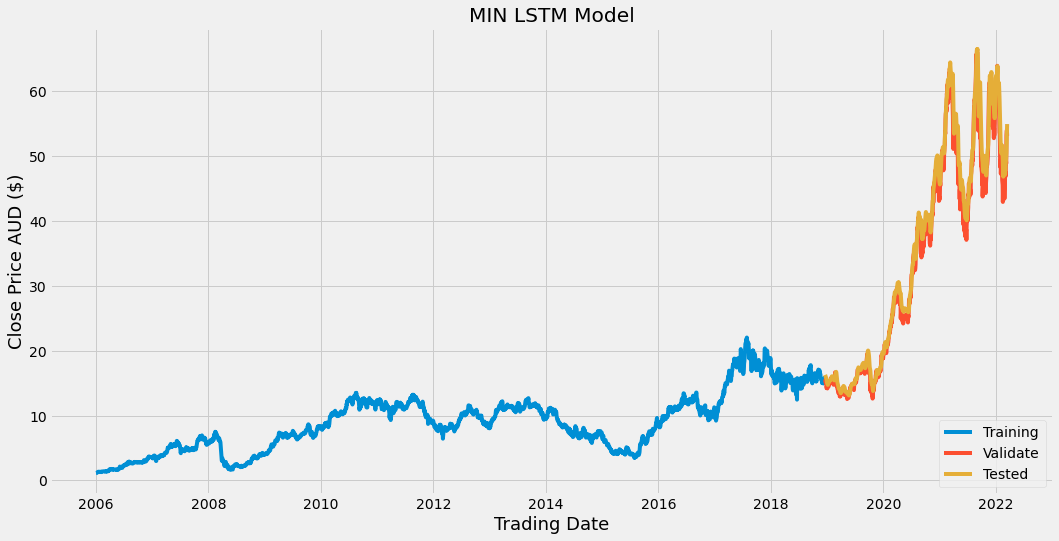

In [26]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('MIN LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
# x = np.arange(2006,2022,9)
plt.xticks([0,500,1000,1500,2000,2500,3000,3500,4000],[2006,2008,2010,2012,2014,2016,2018,2020,2022])
plt.savefig('../static/data/images/min_graph.png')
plt.show()

# Test data Predictions on the Model

In [27]:
valid['Difference']= valid['Close']-valid['Predictions']
valid.head

C:\Users\antoi\AppData\Local\Temp/ipykernel_10620/3403988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


<bound method NDFrame.head of           Close  Predictions  Difference
3241  15.200000    16.261312   -1.061312
3242  15.120000    16.173607   -1.053607
3243  15.560000    15.993298   -0.433298
3244  15.490000    15.915325   -0.425325
3245  14.990000    15.883065   -0.893065
...         ...          ...         ...
4046  48.799999    50.010101   -1.210102
4047  53.209999    50.476162    2.733837
4048  53.740002    51.978756    1.761246
4049  53.959999    53.601261    0.358738
4050  53.080002    54.881241   -1.801239

[810 rows x 3 columns]>

In [28]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.min.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [29]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [30]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price),2)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

02/08/2022 Last close $53.08000183105469 Predicted next day share price $54.55


# Save the Model

In [31]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/min_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list min_sixty and load df

#PREDICT USING LOADED MODEL

In [32]:
from keras.models import load_model
model_in = load_model('../static/min_model.sav')

In [33]:
# query the min collection and load into dataframe

df_mongo = pd.DataFrame(list(db.min.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[51.049999  ],
       [51.849998  ],
       [52.82      ],
       [53.        ],
       [54.259998  ],
       [56.200001  ],
       [59.18      ],
       [57.849998  ],
       [59.130001  ],
       [59.639999  ],
       [60.080002  ],
       [60.115002  ],
       [58.880001  ],
       [61.        ],
       [61.59      ],
       [62.634998  ],
       [58.310001  ],
       [56.619999  ],
       [59.299999  ],
       [59.599998  ],
       [58.990002  ],
       [59.23      ],
       [57.919998  ],
       [55.880001  ],
       [52.720001  ],
       [53.400002  ],
       [52.860001  ],
       [51.279999  ],
       [48.049999  ],
       [48.639999  ],
       [48.080002  ],
       [46.529999  ],
       [46.650002  ],
       [48.509998  ],
       [48.5       ],
       [48.645     ],
       [47.919998  ],
       [46.27      ],
       [45.299999  ],
       [45.509998  ],
       [42.75      ],
       [44.        ],
       [45.869999  ],
       [46.00999832],
       [44.31000137],
       [43

In [34]:
# workings for scatterplot
# df_mongo_min = pd.DataFrame(list(db.min.find()))
# df_min = df_mongo_min.iloc[-4250:]
# min_dict = df_min.to_dict(orient='records')
# #print(min_dict)

#Create a function to loop through the days input

In [35]:
from keras.models import load_model
model_in = load_model('../static/min_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_min(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_min(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[52.56,
 52.95,
 53.1,
 53.12,
 53.09,
 53.04,
 52.99,
 52.95,
 52.95,
 52.97,
 53.03,
 53.12,
 53.24,
 53.39,
 53.56,
 53.75,
 53.94,
 54.15,
 54.36,
 54.57,
 54.77,
 54.98,
 55.16,
 55.28,
 55.41,
 55.55,
 55.68,
 55.81,
 55.93,
 56.05,
 56.17,
 56.3,
 56.43,
 56.56,
 56.7,
 56.85,
 56.99,
 57.14,
 57.3,
 57.46,
 57.62,
 57.77,
 57.93,
 58.09,
 58.25,
 58.41,
 58.57,
 58.74,
 58.9,
 59.02,
 59.14,
 59.28,
 59.41,
 59.52,
 59.62,
 59.73,
 59.81,
 59.83,
 59.9,
 59.96,
 60.02,
 60.07,
 60.13,
 60.19,
 60.25,
 60.32,
 60.39,
 60.46,
 60.54,
 60.62,
 60.7,
 60.78,
 60.87,
 60.95,
 61.03,
 61.11,
 61.18,
 61.25,
 61.33,
 61.39,
 61.46,
 61.52,
 61.58,
 61.65,
 61.71,
 61.77,
 61.82,
 61.88,
 61.94,
 62.0,
 62.05,
 62.11,
 62.17,
 62.22,
 62.28,
 62.33,
 62.39,
 62.44,
 62.49,
 62.54,
 62.59,
 62.63,
 62.68,
 62.72,
 62.77,
 62.81,
 62.85,
 62.89,
 62.92,
 62.96,
 63.0,
 63.03,
 63.06,
 63.1,
 63.13,
 63.16,
 63.2,
 63.23,
 63.26,
 63.29,
 63.33,
 63.36,
 63.39,
 63.42,
 63.46,
 63.49,
 63

In [36]:
import pandas as pd
dates_df = pd.read_csv("../static/data/dates.csv")
dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
dates_df


,Count,Date,DOW
0,1,11/07/2022,Monday
1,2,12/07/2022,Tuesday
2,3,13/07/2022,Wednesday
3,4,14/07/2022,Thursday
4,5,15/07/2022,Friday
...,...,...,...
260,261,10/07/2023,Monday
261,262,11/07/2023,Tuesday
262,263,12/07/2023,Wednesday
263,264,13/07/2023,Thursday


C:\Users\antoi\AppData\Local\Temp/ipykernel_10620/2474989974.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


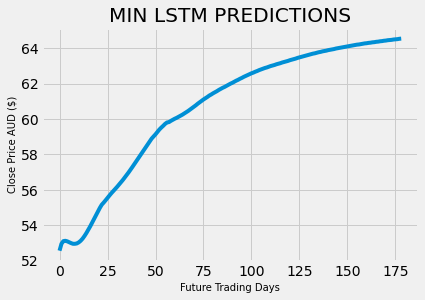

In [37]:
# DRAW THE PREDICTION
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:(input-1)]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('MIN LSTM PREDICTIONS')
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.savefig('../static/data/images/pred/min_pred.png', bbox_inches="tight")
plt.show()

In [38]:
#Append the input amount of trading days to dates dictionary
my_dict = dates_df_iloc.to_dict(orient='records')
my_dict
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
price_dict

[{'Price': 52.56},
 {'Price': 52.95},
 {'Price': 53.1},
 {'Price': 53.12},
 {'Price': 53.09},
 {'Price': 53.04},
 {'Price': 52.99},
 {'Price': 52.95},
 {'Price': 52.95},
 {'Price': 52.97},
 {'Price': 53.03},
 {'Price': 53.12},
 {'Price': 53.24},
 {'Price': 53.39},
 {'Price': 53.56},
 {'Price': 53.75},
 {'Price': 53.94},
 {'Price': 54.15},
 {'Price': 54.36},
 {'Price': 54.57},
 {'Price': 54.77},
 {'Price': 54.98},
 {'Price': 55.16},
 {'Price': 55.28},
 {'Price': 55.41},
 {'Price': 55.55},
 {'Price': 55.68},
 {'Price': 55.81},
 {'Price': 55.93},
 {'Price': 56.05},
 {'Price': 56.17},
 {'Price': 56.3},
 {'Price': 56.43},
 {'Price': 56.56},
 {'Price': 56.7},
 {'Price': 56.85},
 {'Price': 56.99},
 {'Price': 57.14},
 {'Price': 57.3},
 {'Price': 57.46},
 {'Price': 57.62},
 {'Price': 57.77},
 {'Price': 57.93},
 {'Price': 58.09},
 {'Price': 58.25},
 {'Price': 58.41},
 {'Price': 58.57},
 {'Price': 58.74},
 {'Price': 58.9},
 {'Price': 59.02},
 {'Price': 59.14},
 {'Price': 59.28},
 {'Price': 59.41}

In [39]:
# len_df_mongo = len(df.index) # length of the original dataframe
len_df_mongo=len(df_mongo)
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs
print(train_data_len,len_df_mongo,len_pred_df)
new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)

3241 4051 4214


,Close
4203,64.43
4204,64.44
4205,64.46
4206,64.47
4207,64.48
4208,64.50
4209,64.51
4210,64.52
4211,64.54
4212,64.55


C:\Users\antoi\AppData\Local\Temp/ipykernel_10620/1227892185.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


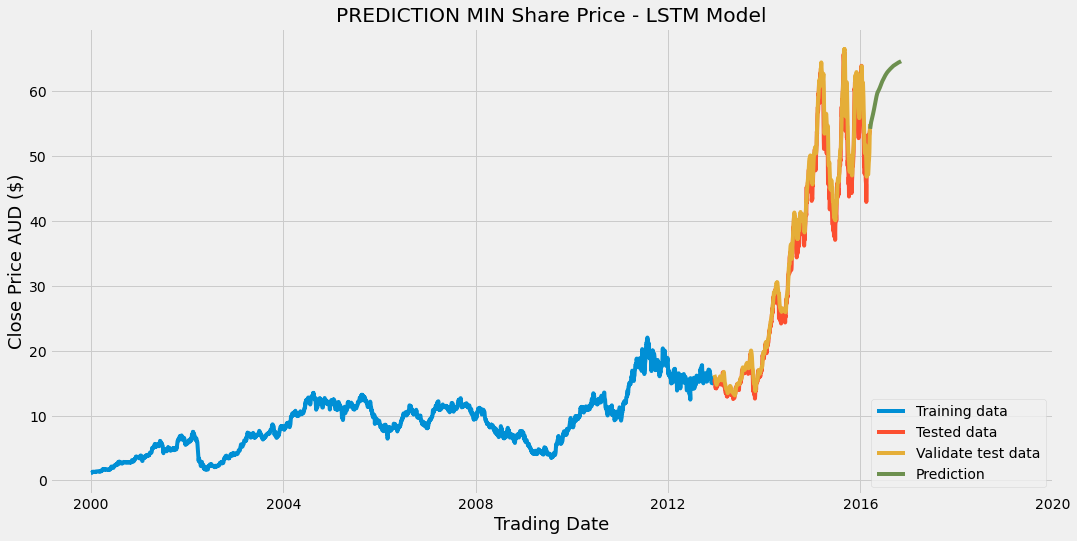

In [40]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION MIN Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/min_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [41]:
# Query all
name = 'MIN'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)


{'_id': ObjectId('62dfa392f178c5283b8b5648'), 'model': 'RFR', 'name': 'MIN', 'date': '22/07/2022', 'predicted': 38, 'actual': 46, 'differece': -7.74920083942115, 'accuracy': 93.63}
{'_id': ObjectId('62e231a1127d7076c5d68361'), 'model': 'LSTM', 'name': 'MIN', 'date': '28/07/2022', 'predicted': 47.41, 'actual': 53.21, 'differece': -5.800000000000004, 'rmse': 0.46379}


In [42]:
# Delete a document from a collection
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62dfa392f178c5283b8b5648'), 'model': 'RFR', 'name': 'MIN', 'date': '22/07/2022', 'predicted': 38, 'actual': 46, 'differece': -7.74920083942115, 'accuracy': 93.63}


In [43]:
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_date},predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 02/08/2022,predicted $54.55, actual $53.08, difference 1.4699999999999989, rmse 1.15967


In [44]:
# Insert a document into the 'companys' collection
db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62dfa392f178c5283b8b5648'), 'model': 'RFR', 'name': 'MIN', 'date': '22/07/2022', 'predicted': 38, 'actual': 46, 'differece': -7.74920083942115, 'accuracy': 93.63}
{'_id': ObjectId('62e8dca0b10b641fd8c7ccc0'), 'model': 'LSTM', 'name': 'MIN', 'date': '02/08/2022', 'predicted': 54.55, 'actual': 53.08, 'difference': 1.47, 'rmse': 1.15967}


In [45]:
# query all the classroom collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62df8ae0427af058c4334ede'), 'model': 'RFR', 'name': 'CBA', 'date': '26/07/2022', 'predicted': 97, 'actual': 96, 'differece': 1.0204273335669143, 'accuracy': 97.43}
{'_id': ObjectId('62dfa392f178c5283b8b5648'), 'model': 'RFR', 'name': 'MIN', 'date': '22/07/2022', 'predicted': 38, 'actual': 46, 'differece': -7.74920083942115, 'accuracy': 93.63}
{'_id': ObjectId('62dfa4d3643d249dfcfea5f3'), 'model': 'RFR', 'name': 'NAB', 'date': '26/07/2022', 'predicted': 28, 'actual': 29, 'differece': -0.9521357946721061, 'accuracy': 97.23}
{'_id': ObjectId('62e219cf92eb597dfa71446b'), 'model': 'LSTM', 'name': 'NAB', 'date': '28/07/2022', 'predicted': 29.89, 'actual': 30.28, 'differece': -0.39000000000000057, 'rmse': 0.4037}
{'_id': ObjectId('62e22127c7e5ff501a0a119c'), 'model': 'LSTM', 'name': 'WBC', 'date':